In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyreadr
from datetime import date

### 3. statistical model for election

**poll aggregators**

In [2]:
# generate polls

In [3]:
def generate_polls(p,N):
    vote = np.zeros(N)
    prob = np.random.rand(N)
    vote[prob<=p] = 1
    return vote

In [4]:
p = (0.039+1) / 2
size = [1298, 533, 1342, 897, 774, 254, 812, 324, 1291, 1056, 2172, 516]
polls = [generate_polls(p,N) for N in size]

In [5]:
# compare predict

In [6]:
def pred_vote(poll,conf):
    mu = np.mean(poll)
    sig = np.sqrt(mu * (1-mu) / np.size(poll))
    est = 2*mu-1
    return [est, 2*(mu-(1+conf)*sig)-1, 2*(mu+(1+conf)*sig)-1]

In [7]:
est = [pred_vote(poll,0.95) for poll in polls]
est.append(pred_vote(np.hstack(polls), 0.95))
est = np.array(est)

In [8]:
# visualization

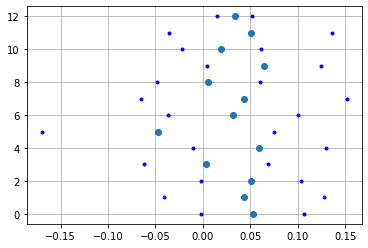

In [9]:
plt.plot(est[:,0], range(13), 'o', est[:,1:], range(13), 'b.')
plt.grid()
plt.show()

In [10]:
# prediction for 2016 president election

In [11]:
rdata = pyreadr.read_r('polls_us_election_2016.rda')

In [12]:
print(rdata.keys())

odict_keys(['polls_us_election_2016', 'results_us_election_2016'])


In [13]:
polls = rdata['polls_us_election_2016'].copy()

In [14]:
polls.loc[:,:] = polls[(polls['state']=='U.S.') & (polls['enddate']>=date(2016,10,31)) & \
              (polls['grade'].isin(['A+','A','A-','B+'])|polls['grade'].isna())]
polls['spread'] = (polls['rawpoll_clinton'] - polls['rawpoll_trump']) / 100

In [15]:
polls.head(3)

,state,startdate,enddate,pollster,grade,samplesize,population,rawpoll_clinton,rawpoll_trump,rawpoll_johnson,rawpoll_mcmullin,adjpoll_clinton,adjpoll_trump,adjpoll_johnson,adjpoll_mcmullin,spread
0,U.S.,2016-11-03,2016-11-06,ABC News/Washington Post,A+,2220,lv,47.0,43.0,4.0,NaN,45.20163,41.7243,4.626221,NaN,0.04
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,U.S.,2016-11-02,2016-11-06,Ipsos,A-,2195,lv,42.0,39.0,6.0,NaN,42.02638,38.8162,6.844734,NaN,0.03


In [16]:
polls.shape

(4208, 16)

In [17]:
# is 'd' normally distributed in prediction by different pollsters? No.

In [18]:
d_est = polls['spread'] @ polls['samplesize'] / polls['samplesize'].sum()
p_est = (1+d_est)/2
s_est = 1.95 * 2 * np.sqrt(p_est*(1-p_est)/polls['samplesize'].sum()) # why multiple 1.96 for 95% confidence interval?
d_est, p_est, s_est

(nan, nan, nan)

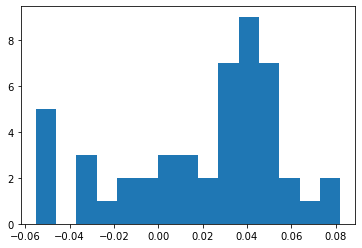

In [19]:
plt.hist(polls['spread'], bins=15)
plt.show()

In [20]:
# the bias of pollsters

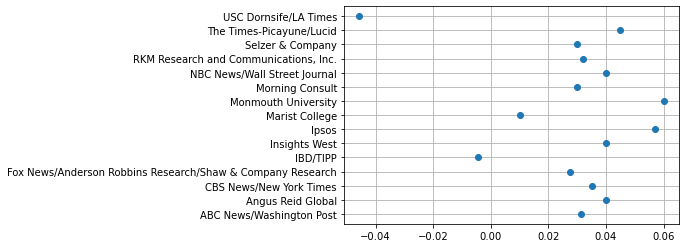

In [21]:
polls_pollster_d_est = polls.groupby(['pollster']).mean()['spread'].dropna()
plt.plot(polls_pollster_d_est, polls_pollster_d_est.index, 'o')
plt.grid()
plt.show()

Prior assumption for distribution and pollster bias lead to deviation from reality, thus the data-driven models are inrtoduced next.

**data-driven models**

In [22]:
polls_pollster_newest = polls.groupby('pollster', group_keys=False).apply(lambda x: x[x['enddate'] == x['enddate'].max()])

In [23]:
d_est = polls_pollster_newest['spread'].mean()
s_est = np.sqrt(polls_pollster_newest['spread'].var()) / np.sqrt(np.size(polls_pollster_newest['spread']))
d_est, s_est, d_est-1.95*s_est, d_est+1.95*s_est

(0.02898, 0.006246783553310037, 0.016798772071045426, 0.041161227928954575)

Data-driven models describe variability from sampling together with variability from pollster bias. Futhermore, variabilities at different levels can be modeled by more complex approaches. One of the most successful approaches used for this are hierarchical models, which can be explained in the context of Bayesian statistics. Next we build a hierarchical model using Bayesian statistics.

Assume prior distribution of d is normal distribution with aveage 0 and standard deviation 0.035.

In [24]:
mu = 0
tau = 0.035
B = s_est**2 / (s_est**2 + tau**2)
post_d = B * mu + (1-B) * d_est
post_s = np.sqrt(1/(1/s_est**2+1/tau**2))
post_d, post_s, post_d-1.95*post_s, post_d+1.95*post_s

(0.028085343008790484,
 0.0061496037628464865,
 0.016093615671239837,
 0.04007707034634113)

Parameters of prior distribution should come from history data in real prediction. Because the prior distribution used here has little relation to reality, it did not help predict better.

There is a commmon bias for polls conducted by any pollster. Why can not eliminate this common bias by subtraction of two polls?

Decompose the result of one poll into the true spread, the randomness induced by pollster and the randomness induced by polling.

In [25]:
p = (0.021+1) / 2  # 0.021 is supposed real spread
h = np.random.normal(loc=0.0, scale=0.025, size=(1,5))  # h is the randomness induced by pollster
epi = np.random.normal(loc=0.0, scale=2*np.sqrt(p*(1-p)/2000), size=(6,5))  # epi is the randomness induced by polling 2000 is the assumed size of poll
sample = 0.021 + h + epi

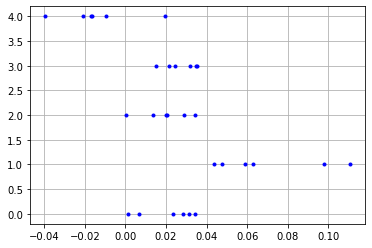

In [26]:
plt.plot(sample.T[:,:], range(5), 'b.')
plt.grid()
plt.show()

Considering the common bias, we modify the Bayesian procedure used at the beginning.

In [27]:
mu = 0
tau = 0.035
s_modified = np.sqrt(s_est**2+0.025**2)  # 0.025 is the standard deviation of common bias estimated from historial data
B = s_modified**2 / (s_modified**2 + tau**2)
post_d = B * mu + (1-B) * d_est
post_s = np.sqrt(1/(1/s_modified**2+1/tau**2))
post_d, post_s, post_d-1.95*post_s, post_d+1.95*post_s

(0.018793054963146413,
 0.020751086238080068,
 -0.021671563201109717,
 0.059257673127402544)

Predict for the president of U.S. using electoral college vote method.

In [28]:
polls = rdata['polls_us_election_2016'].copy()
results = rdata['results_us_election_2016'].copy()

In [29]:
polls = polls[(polls['state']!='U.S.') & (~polls['state'].str.contains('CD')) & (polls['enddate']>=date(2016,10,31))\
                                           & (polls['grade'].isin(['A+','A','A-','B+'])|polls['grade'].isna())]
polls['spread'] = (polls['rawpoll_clinton'] - polls['rawpoll_trump']) / 100

In [30]:
polls.head(5)

,state,startdate,enddate,pollster,grade,samplesize,population,rawpoll_clinton,rawpoll_trump,rawpoll_johnson,rawpoll_mcmullin,adjpoll_clinton,adjpoll_trump,adjpoll_johnson,adjpoll_mcmullin,spread
8,New Mexico,2016-11-06,2016-11-06,Zia Poll,NaN,8439,lv,46.0,44.0,6.0,NaN,44.82594,41.59978,7.870127,NaN,0.02
13,Virginia,2016-11-03,2016-11-04,Public Policy Polling,B+,1238,lv,48.0,43.0,1.0,NaN,47.43805,42.32751,2.207659,NaN,0.05
15,Iowa,2016-11-01,2016-11-04,Selzer & Company,A+,800,lv,39.0,46.0,6.0,NaN,39.37561,45.66917,6.062713,NaN,-0.07
17,Wisconsin,2016-10-26,2016-10-31,Marquette University,A,1255,lv,46.0,40.0,4.0,NaN,46.10344,40.97982,2.897062,NaN,0.06
18,North Carolina,2016-11-04,2016-11-06,Siena College,A,800,lv,44.0,44.0,3.0,NaN,44.21875,45.08290,2.335250,NaN,0.00


In [69]:
ave = polls.groupby('state')['spread'].mean().rename('ave')
std = polls.groupby('state')['spread'].std().rename('std')
size = polls.groupby('state')['spread'].count().rename('size')
pre_state = pd.concat([ave, std, size], axis=1).dropna(subset=['ave'])
pre_state.fillna(pre_state['std'].mean(), inplace=True)
pre_state = pre_state.sort_values(by=['ave'], key=lambda col: col.abs())
pre_state = pre_state.merge(results, how='left', on='state')
pre_state.head(5)

,state,ave,std,size,electoral_votes,clinton,trump,others
0,Florida,0.003557,0.016350,7,29,47.8,49.0,3.2
1,North Carolina,-0.007300,0.030621,9,15,46.2,49.8,4.0
2,Ohio,-0.010417,0.025225,6,18,43.5,51.7,4.8
3,Nevada,0.016857,0.044068,7,6,47.9,45.5,6.6
4,Iowa,-0.019733,0.043665,3,6,41.7,51.1,7.1


In [70]:
results[~results['state'].isin(pre_state['state'])]

,state,electoral_votes,clinton,trump,others
42,Rhode Island,4,54.4,38.9,6.7
43,Alaska,3,36.6,51.3,12.2
49,Wyoming,3,21.9,68.2,10.0
50,District of Columbia,3,90.9,4.1,5.0


In [71]:
# Bayesian Method
mu = 0
tau = 0.02
pre_state['sigma'] = pre_state['std'] / np.sqrt(pre_state['size'])
pre_state['B'] = pre_state['sigma']**2 / (pre_state['sigma']**2 + tau**2)
pre_state['post_ave'] = pre_state['B'] * mu + (1-pre_state['B']) * pre_state['ave']
pre_state['post_std'] = np.sqrt(1 / (1/pre_state['sigma']**2 + 1/tau**2))
pre_state.head(5)

,state,ave,std,size,electoral_votes,clinton,trump,others,sigma,B,post_ave,post_std
0,Florida,0.003557,0.016350,7,29,47.8,49.0,3.2,0.006180,0.087148,0.003247,0.005904
1,North Carolina,-0.007300,0.030621,9,15,46.2,49.8,4.0,0.010207,0.206635,-0.005792,0.009091
2,Ohio,-0.010417,0.025225,6,18,43.5,51.7,4.8,0.010298,0.209562,-0.008234,0.009156
3,Nevada,0.016857,0.044068,7,6,47.9,45.5,6.6,0.016656,0.409531,0.009954,0.012799
4,Iowa,-0.019733,0.043665,3,6,41.7,51.1,7.1,0.025210,0.613727,-0.007622,0.015668


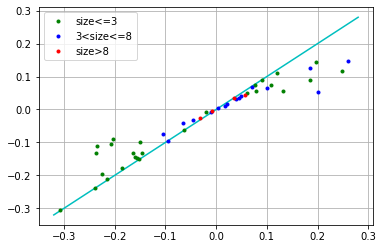

In [87]:
# visualize how Bayesian Method rebuild 'ave' regard to different size
plt.plot([-0.32,0.28], [-0.32,0.28], 'c')
plt.plot(pre_state[pre_state['size']<=3]['ave'], pre_state[pre_state['size']<=3]['post_ave'], 'g.', label='size<=3')
plt.plot(pre_state[(pre_state['size']>3) & (pre_state['size']<=8)]['ave'], \
         pre_state[(pre_state['size']>3) & (pre_state['size']<=8)]['post_ave'], 'b.', label='3<size<=8')
plt.plot(pre_state[pre_state['size']>8]['ave'], pre_state[pre_state['size']>8]['post_ave'], 'r.', label='size>8')
plt.legend()
plt.grid()
plt.show()

In [97]:
N = 10000
results = np.zeros(N)
for i in range(N):
    sample = np.random.normal(pre_state['post_ave'], pre_state['post_std'])
    results[i] = pre_state[sample>0]['electoral_votes'].sum()+7
(results>269).sum() / N

0.9988

modify the "std" to include the influence of common bias.

In [98]:
mu = 0
tau = 0.02
sigma_b = 0.03
pre_state['sigma_modified'] = np.sqrt(pre_state['std']**2 / pre_state['size'] + sigma_b**2)
pre_state['B_modified'] = pre_state['sigma_modified']**2 / (pre_state['sigma_modified']**2 + tau**2)
pre_state['post_ave_modified'] = pre_state['B_modified'] * mu + (1-pre_state['B_modified']) * pre_state['ave']
pre_state['post_std_modified'] = np.sqrt(1 / (1/pre_state['sigma_modified']**2 + 1/tau**2))

In [103]:
N = 10000
results_modified = np.zeros(N)
for i in range(N):
    sample = np.random.normal(pre_state['post_ave_modified'], pre_state['post_std_modified'])
    results_modified[i] = pre_state[sample>0]['electoral_votes'].sum()+7
(results_modified>269).sum() / N

0.8378

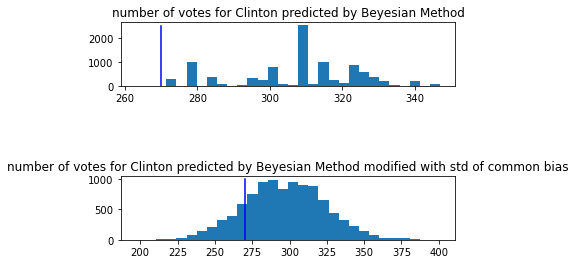

In [112]:
plt.subplot(3, 1, 1)
plt.hist(results, bins=30)
plt.plot([270,270], [0,2500], 'b')
plt.title("number of votes for Clinton predicted by Beyesian Method")
plt.subplot(3, 1, 3)
plt.hist(results_modified, bins=30)
plt.plot([270,270], [0,1000], 'b')
plt.title("number of votes for Clinton predicted by Beyesian Method modified with std of common bias")
plt.show()

Visualize how time affect polling.

In [113]:
polls = rdata['polls_us_election_2016'].copy()
polls = polls[(polls['state']=='U.S.') & (polls['pollster']=='Ipsos')]
polls['spread'] = (polls['rawpoll_clinton'] - polls['rawpoll_trump']) / 100
empirical_std = polls['spread'].std()
theoretical_std = 2 * np.sqrt(polls['spread'].mean() * (1-polls['spread'].mean()) / polls['samplesize'].min())
empirical_std, theoretical_std

(0.04025194279020039, 0.03256718644795854)

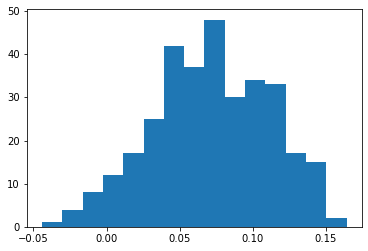

In [114]:
plt.hist(polls['spread'], bins=15)
plt.show()

The empirical_std does not match with the theoretical_std and the histgram of spread polled by Iposo is not consistent with normal distribution. Since we have eliminated the variability between pollsters, where is this extra variability come from? We intorduce a new term concerning time: $$Y_{i,j,t} = d + b + h_j + b_t + \epsilon_{i,j,t}$$

### 4. 
张某为了解自己患上了X疾病的可能性，去医院作常规血液检查。其结果居然为阳性，他赶忙到网上查询。根据网上的资料，血液检查实验是有误差的，这种实验有“1%的假阳性率和1%的假阴性率”（真的患病者得到阴性结果称为假阴性，未患病的人得到阳性结果称为假阳性）。即在得病的人中做实验，有1%的概率是假阴性，99％是真阳性。而在未得病的人中做实验，有1%的概率是假阳性，99％是真阴性。于是张某根据这种解释，估计他自己得了X疾病的概率为99%。张某的推理是，既然只有1%的假阳性率，那么，99%都是真阳性，那我已被感染X病的概率便应该是99%。
张某咨询了医生，医生说：“99%？哪有那么大的感染几率啊。99％是测试的准确性，不是你得病的概率。你忘了一件事：这种X疾病的正常比例是不大的，1000个人中只有一个人有X病。”
张某不放心，又做了一个尿液检查，进一步检查他患上了X疾病的可能性，其结果仍然为阳性，尿液检查的实验有“5%的假阳性率和5%的假阴性率”。


**(a)** 张某初始计算感染X病的概率是99%，问题出在哪？

此处99%指的是接受测试者患病的条件下，检测为阳性的概率是99%。而张某关心的是检测为阳性的条件下，接收测试者患病的概率。这两者是不同的。

**(b)** 张某在血液检查之后感染X病的概率是多少？

P(患病|血液检测阳性)=P(患病，血液检测阳性)/P(血液检测阳性)=(1/1000) * (99/100) / ((1/1000) * (99/100) + (999/1000) * (1/100))，约为9%.

**(c)** 张某在血液和尿液检查之后得X病的概率是多少？

P(患病|血液检测阳性且尿液检查阳性)=P(患病，血液检测阳性且尿液检查阳性)/P(血液检测阳性且尿液检查阳性)=(1/1000) * (99/100) * (95/100) / ((1/1000) * (99/100) * (95/100) + (999/1000) * (1/100) * (5/100))，约为65%.

**(d)** 如果根据张某的家族遗传信息，他得X病的概率是百分之一，请问结合血液和尿液检查结果，张某得X病的概率是多少？

P(患病|血液检测阳性且尿液检查阳性)=P(患病，血液检测阳性且尿液检查阳性)/P(血液检测阳性且尿液检查阳性)=(1/100) * (99/100) * (95/100) / ((1/100) * (99/100) * (95/100) + (99/100) * (1/100) * (5/100))，约为95%.

### 5. 
设想要对研究生论文抄袭现象进行社会调查。如果直接就此问题进行问卷调查，即使是无记名的，也会使被调查者感到尴尬。设计如下方案可使被调查者愿意做出真实的回答。
在一个箱子里放进1个红球和1个白球。被调查者在摸到球后记住颜色并立刻将球放回，然后根据球的颜色分别回答如下问题。
如果球是红色：你的生日是否在7月1日以前？
如果球是白色：你做论文时是否有过抄袭行为？

回答时只要在一张预备好的白纸上打√或打×，分别表示是或否。
假定被调查者有150人，统计出有60个√，有抄袭行为的比率大概是多少？

P(回答是|抽到白色球)=N(回答是，抽到白色球)/N(抽到白色球)=(N(回答是)-N(回答是，抽到红色球))/N(抽到白色球)=0.3，大概为30%.

### 6. 
什么是模型？观测数据、模型与真实的世界的关系？新冠疫情是否可预测？结合COVID-19 作为实例。

模型是现实世界的简化版，去除现实世界中我们不关心的部分，去除现实世界中和我们关心的问题弱相关的部分，抽象现实世界中和我们关心的问题强相关的部分。这样经过简化和抽象得到的模型有助于我们理解现实世界，并且求解它的结果有助于指导现实生活。观测数据是认识现实世界的一种渠道，我们基于对现实世界的经验理解和观测数据建立模型。尽管许多对新冠疫情所做的预测都被时间否定了，但新冠疫情并非不可预测，预测结果有误可能是由于信息不足或模型有误产生的，通过囊括更多的有效信息和构建更能反映现实世界的模型，我们就能做出更精确的预测。

### 7. 
从三个实例的解读，你理解的数据建模的要素和流程？举一个数据建模的例子来支持自己的观点。

首先是对数据的探索性分析（主观臆测不可取，需要通过对数据的探索性分析来建立对问题的准确认识），接下来是基于对问题的认识构建模型（这中间可能需要根据模型求解的结果反复修改初始模型），最后是对预测结果的信度，模型的鲁棒性，敏感性等风险说明方面的计算。比如上文第3题的总统选举结果预测的例子。